# Where's Waldo?

Importing the data

In [1]:
# !pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("residentmario/wheres-waldo")

print("Path to dataset files:", path)

Path to dataset files: /Users/laurenbeede/.cache/kagglehub/datasets/residentmario/wheres-waldo/versions/2


/Users/laurenbeede/miniconda3/envs/sp25/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Testing the images of Waldo

In [3]:
import matplotlib.pyplot as plt
import os
datapath = path+'/wheres-waldo/Hey-Waldo'

In [ ]:
os.listdir(datapath + '/256/notwaldo')
# plt.imshow(im)

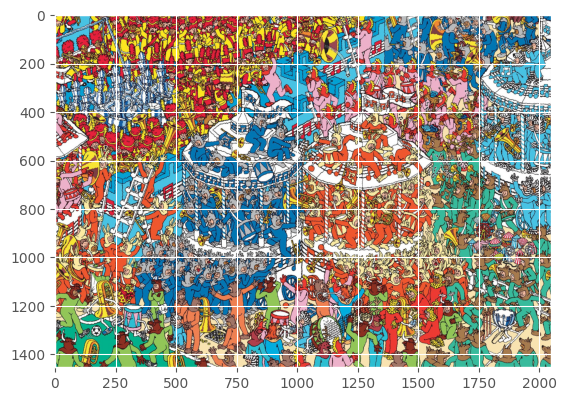

In [28]:
im = plt.imread(datapath+"/original-images/6.jpg")
plt.imshow(im)

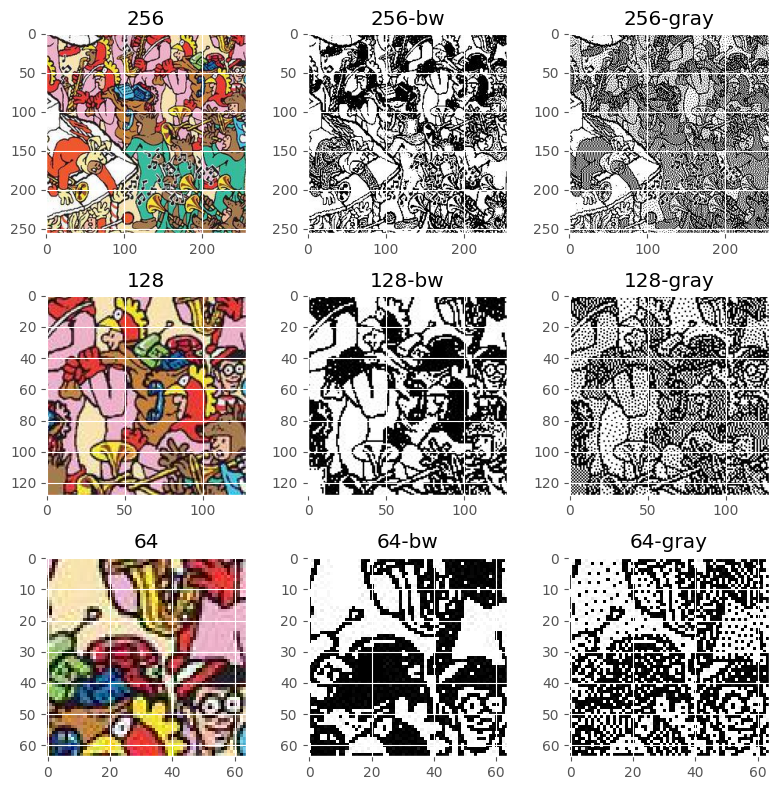

In [24]:
fig, axarr = plt.subplots(3, 3, figsize=(8, 8))

im = plt.imread(datapath+"/256/waldo/10_3_1.jpg")
axarr[0][0].imshow(im)
axarr[0][0].set_title("256")

im = plt.imread(datapath+"/256-bw/waldo/10_3_1.jpg")
axarr[0][1].imshow(im)
axarr[0][1].set_title("256-bw")

im = plt.imread(datapath+"/256-gray/waldo/10_3_1.jpg")
axarr[0][2].imshow(im)
axarr[0][2].set_title("256-gray")

im = plt.imread(datapath+"/128/waldo/10_7_2.jpg")
axarr[1][0].imshow(im)
axarr[1][0].set_title("128")

im = plt.imread(datapath+"/128-bw/waldo/10_7_2.jpg")
axarr[1][1].imshow(im)
axarr[1][1].set_title("128-bw")

im = plt.imread(datapath+"/128-gray/waldo/10_7_2.jpg")
axarr[1][2].imshow(im)
axarr[1][2].set_title("128-gray")

im = plt.imread(datapath+"/64/waldo/10_15_4.jpg")
axarr[2][0].imshow(im)
axarr[2][0].set_title("64")

im = plt.imread(datapath+"/64-bw/waldo/10_15_4.jpg")
axarr[2][1].imshow(im)
axarr[2][1].set_title("64-bw")

im = plt.imread(datapath+"/64-gray/waldo/10_15_4.jpg")
axarr[2][2].imshow(im)
axarr[2][2].set_title("64-gray")

plt.tight_layout()

Problems include:  
- Waldo as differs in size
- Many more not-waldo images than waldo images
- Waldo can be obstructed

## Object detecting

Installing dependencies

In [5]:
# !pip install torch
# !pip install torchvision
# !pip install imutils
# !pip install matplotlib
# !pip install numpy
# !pip install tqdm

In [6]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn ## Pre-trained model from PyTorch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [7]:
numnotwaldo = len(os.listdir(datapath+'/128/notwaldo/'))
numwaldo = len(os.listdir(datapath+'/128/waldo/'))

In [8]:
print(f"There are {numwaldo} images of Waldo")
print(f"There are {numnotwaldo} images of not Waldo")

There are 27 images of Waldo
There are 1317 images of not Waldo


In [9]:
import config
from xml_to_csv import convert_each_xml_to_csv
from bbox_regressor import ObjectDetector
from custom_tensor_dataset import CustomTensorDataset

In [10]:
print(f"Base path: {config.BASE_PATH}")
print(f"Annotation path: {config.ANNOTS_PATH}")
print(f"Annotation path: {config.IMAGES_PATH}")
print(f"Ouput path: {config.BASE_OUTPUT}")

Base path: /Users/laurenbeede/FindWaldo
Annotation path: /Users/laurenbeede/FindWaldo/csv_output
Annotation path: /Users/laurenbeede/FindWaldo/annotations/imgs/original_imgs
Ouput path: /Users/laurenbeede/FindWaldo/output


In [11]:
xml_folder = "/Users/laurenbeede/FindWaldo/annotations/imgs/bnd_box"
output_folder = "/Users/laurenbeede/FindWaldo/csv_output"

In [12]:
if os.path.exists(output_folder):
    print(f"Output folder {output_folder} already exists.")
else:
    convert_each_xml_to_csv(xml_folder, output_folder)

Output folder /Users/laurenbeede/FindWaldo/csv_output already exists.


[INFO] loading dataset...
[INFO] total training samples: 14...
[INFO] total test samples: 4...
[INFO] saving testing image paths...


/Users/laurenbeede/miniconda3/envs/sp25/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/laurenbeede/miniconda3/envs/sp25/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ObjectDetector(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

  5%|▌         | 1/20 [00:00<00:07,  2.42it/s]

[INFO] EPOCH: 1/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 10%|█         | 2/20 [00:00<00:07,  2.37it/s]

[INFO] EPOCH: 2/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 15%|█▌        | 3/20 [00:01<00:07,  2.41it/s]

[INFO] EPOCH: 3/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 20%|██        | 4/20 [00:01<00:06,  2.40it/s]

[INFO] EPOCH: 4/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 25%|██▌       | 5/20 [00:02<00:06,  2.46it/s]

[INFO] EPOCH: 5/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 30%|███       | 6/20 [00:02<00:05,  2.49it/s]

[INFO] EPOCH: 6/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 35%|███▌      | 7/20 [00:02<00:05,  2.50it/s]

[INFO] EPOCH: 7/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 40%|████      | 8/20 [00:03<00:04,  2.48it/s]

[INFO] EPOCH: 8/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 45%|████▌     | 9/20 [00:03<00:04,  2.50it/s]

[INFO] EPOCH: 9/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 50%|█████     | 10/20 [00:04<00:03,  2.53it/s]

[INFO] EPOCH: 10/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 55%|█████▌    | 11/20 [00:04<00:03,  2.57it/s]

[INFO] EPOCH: 11/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 60%|██████    | 12/20 [00:04<00:03,  2.41it/s]

[INFO] EPOCH: 12/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 65%|██████▌   | 13/20 [00:05<00:02,  2.43it/s]

[INFO] EPOCH: 13/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 70%|███████   | 14/20 [00:05<00:02,  2.47it/s]

[INFO] EPOCH: 14/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 75%|███████▌  | 15/20 [00:06<00:02,  2.47it/s]

[INFO] EPOCH: 15/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 80%|████████  | 16/20 [00:06<00:01,  2.48it/s]

[INFO] EPOCH: 16/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 85%|████████▌ | 17/20 [00:06<00:01,  2.45it/s]

[INFO] EPOCH: 17/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 90%|█████████ | 18/20 [00:07<00:00,  2.46it/s]

[INFO] EPOCH: 18/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


 95%|█████████▌| 19/20 [00:07<00:00,  2.44it/s]

[INFO] EPOCH: 19/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]

[INFO] EPOCH: 20/20
Train loss: inf, Train accuracy: 1.0000
Val loss: inf, Val accuracy: 1.0000
[INFO] total time taken to train the model: 8.12s
[INFO] saving object detector model...
[INFO] saving label encoder...


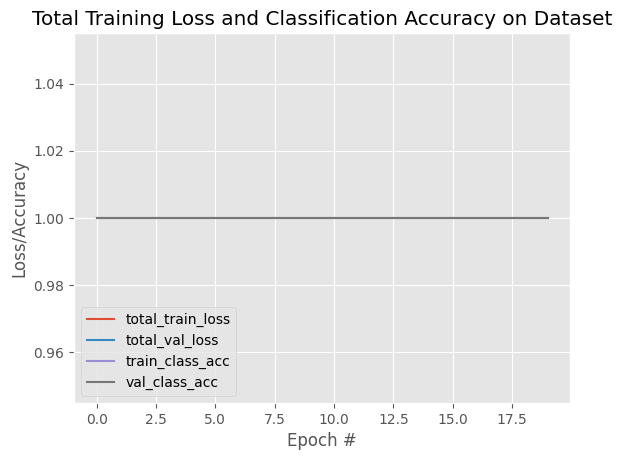

In [14]:
%run train.py